## Increasing Diversity Hiring in City of LA through Text and Sentiment Analysis of Job Postings

**Challenge:**

The City of Los Angeles faces a big hiring challenge: one third of its 50,000 workers are eligible to retire by July of 2020. The city has partnered with Kaggle to create a competition to improve the job bulletins it will use to fill all those open positions.
The content, tone, and format of job descriptions can influence the quality of the applicant pool. Overly-specific requirements, for example, may discourage diversity. The Los Angeles Mayor’s Office wants to reimagine the city’s job bulletins by using text analysis to identify where they can improve.

**Goal:**
The goal is to convert a folder full of plain-text job postings into a structured CSV file and then to use this data to:
1. Identify language that can negatively bias the pool of applicants; 
2. Improve the diversity and quality of the applicant pool; 
3. Make it easier to determine which promotions are available to employees in each job class.

## PART 1: JOB POSTING TEXT BULLETIN TO STRUCTURED CSV FILE:

First, we will need to import all the neccessary requirements:

In [1]:
#These open source libraries are using python 3.6
import numpy as np 
import pandas as pd 
import re
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import random
import dateutil.parser as dparser
from datetime import datetime
import datefinder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud, STOPWORDS
from flashtext import KeywordProcessor
import os
from __future__ import unicode_literals, print_function
import plac
import spacy

Load the data of job bulletins into a List of text, also load the filenames (to be used later), derive the job position from the filename for some preliminary analysis (actual position for data dictionary will be derived from job bulletin)

In [2]:
def load_jobopening_dataset():

    data_path = 'CityofLA/Job Bulletins'

    texts = []
    positions = []
    file_names=[]
    for fname in sorted(os.listdir(data_path)):
        if fname.endswith('.txt'):
            file_names.append(fname)
            with open(os.path.join(data_path, fname),"rb") as f:
                texts.append(str(f.read()))
                positions.append((re.split(' (?=class)', fname))[0])
    
    #print the length of the List of text, length of file_names and positions and make sure they are all equal
    return (texts,positions,file_names)

job_data, positions, file_names = load_jobopening_dataset()

In [3]:
job_data[0].replace("\\r\\n"," ").replace("\\\'s","")[:250]

"b'311 DIRECTOR Class Code:       9206 Open Date:  04-18-14 ANNUAL SALARY   $125,175 to $155,514   DUTIES  A 311 Director is responsible for the successful operation and expansion of the 311 Call Center in the Information Technology Agency (ITA) which"

**Provided documents:**

In [4]:
titles = pd.read_csv("CityofLA/Additional data/job_titles.csv", header=None)
titles.head()

,0
0,311 DIRECTOR
1,ACCOUNTANT
2,ACCOUNTING CLERK
3,ACCOUNTING RECORDS SUPERVISOR
4,ADMINISTRATIVE ANALYST


In [141]:
data_dict=pd.read_csv("CityofLA/Additional data/kaggle_data_dictionary.csv")
data_dict[:5]

,Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes
0,FILE_NAME,NaN,The file name of the job bulletin from which each record came,String,NaN,No,NaN
1,JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Systems Analyst, Carpenter)",String,Any job title matching in in supplied job bulletins,No,NaN
2,JOB_CLASS_NO,B,The 4-digit code that corresponds to the job class.,String,Any four character numeric string matching one in supplied job bulletins,No,"Some classes have three non-zero digits — e.g., 0162. These will take the form 0###"
3,REQUIREMENT_SET_ID,D1,"A main requirement that has to be filled. These are identified with numbers in the job bulletin. Relationships between requirement sets are specified by an ""AND|OR"" conjunction (data element E1 on the data annotation chart)",Integer,Any positive integer,No,NaN
4,REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled, nested under a REQUIREMENT_SET_ID. These are identified with letters in the job bulletin. Relationships between requirement sub-sets are specified by an ""AND|OR"" conjunction (Data element E2 on the data annotation chart)",String,Any letter or combination of letters.,No,"A-Z represents 1-26. In the case of 27th, 28th, ... sub-requirement, use AA, BB, ..."


**Creating the Parsers:**

In this section, I will create different parsers to extract different information from the text bulletin. Those information are based on the content of sample output file and the field name of data dictionary, which includes:
1. JOB_CLASS_TITLE
2. JOB_CLASS_NO
3. REQUIREMENT_SET_ID
4. REQUIREMENT_SUBSET_ID
5. JOB_DUTIES
6. EDUCATION_YEARS
7. SCHOOL_TYPE
8. EDUCATION_MAJOR
9. EXPERIENCE_LENGTH
10. FULL_TIME_PART_TIME
11. EXP_JOB_CLASS_TITLE
12. EXP_JOB_CLASS_ALT_RESP
13. EXP_JOB_CLASS_FUNCTION
14. COURSE_COUNT
15. COURSE_LENGTH
16. COURSE_SUBJECT
17. MISC_COURSE_DETAILS
18. DRIVERS_LICENSE_REQ
19. DRIV_LIC_TYPE
20. ADDTL_LIC
21. EXAM_TYPE
22. ENTRY_SALARY_GEN
23. ENTRY_SALARY_DWP
24. OPEN_DATE

We would need 24 parsers for 24 collumns of the output csv file, the parsers are defined as function below:

In [6]:
def Position_parser(s):
    title_match=False
    pos = re.findall(r'(.*?)Class Code',s)
    pos1 = re.findall(r'(.*?)Class  Code',s)
    if (len(pos1) > 0):
        pos = pos1
    if (len(pos) > 0):
        job_title= pos[0].replace("b'","").replace("b\"","").replace("'","").replace("\\","").strip()
        for title in titles[0]:
            if (title.replace("'","")==job_title):
                title_match=True
                break
    if(title_match==True):
        return job_title
    else:
        return "Invalid job title" 

In [7]:
def JobCode_parser(s):
    job_code = 0
    code = re.findall(r'Class Code:(.*?)Open',s)
    if (len(code)>0):
        job_code= int(code[0].strip())
    return job_code

In [8]:
def OpenDate_parser(s):
    openDateRet=""
    openDate = re.findall(r'Open Date:(.*?)ANNUAL',s)
    openStr=""
    if (len(openDate)>0):
        #print(openDate)
        openDate = openDate[0].strip()
        openStr=re.findall(r'(?:Exam).*',openDate)
        #print(openStr)
    
    matches = list(datefinder.find_dates(openDate))

    if len(matches) > 0:
        for i in range(len(matches)):
            date = matches[i]
            openDateRet=str(date.date())
    return openDateRet,openStr


In [9]:
def SalaryRange_parser(s):
    salaryRange = re.findall(r'ANNUAL SALARY(.*?)NOTE',s)
    salaryRange_1 = re.findall(r'ANNUAL SALARY(.*?)DUTIES',s)
    salaryRange_2 = re.findall(r'ANNUAL SALARY(.*?)\(flat',s)
    len1=0
    len2=0
    len3=0
    if (len(salaryRange) > 0):
        len1 = len(salaryRange[0])
    if (len(salaryRange_1) > 0):
        len2 = len(salaryRange_1[0])
    if (len(salaryRange_2) > 0):
        len3 = len(salaryRange_2[0])
    if ((len1 > 0) & (len2 > 0)):
        if (len1 < len2):
            salaryRange = salaryRange
        else:
            salaryRange = salaryRange_1
        
    if (len(salaryRange)>0):
        salaryRange = salaryRange[0].strip()
    return salaryRange

In [10]:
def Qualification_parser(s):
    qual = re.findall(r'REQUIREMENTS/MINIMUM QUALIFICATIONS(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENT/MINIMUM QUALIFICATION(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENTS(.*?)WHERE TO APPLY',s)
    if (len(qual)==0):
        qual = re.findall(r'REQUIREMENT(.*?)WHERE TO APPLY',s)
    if (len(qual)>0):
        qual = qual[0].replace("\\'s","'s").strip()
    else:
        qual=""
    return qual

In [11]:
def Education_parser(s):
    educationMajor=""
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "major" in word_tokenize(sent)]
    for i in range(len(selected_sentences)):
        major = re.findall(r'major in(.*?),',selected_sentences[i])
        if (len(major)>0):
            educationMajor=major[0].strip()
    return educationMajor

In [12]:
def EduSemDur_parser(s):
    educationDur=""
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "semester" in word_tokenize(sent)]
    for i in range(len(selected_sentences)):
        dur = re.findall(r'(.*?)semester',selected_sentences[i])
        #print(dur)
        if (len(dur)>0):
            educationDur=dur[0]+'sememster'
    return educationDur

In [13]:
def Duties_parser(s):
    duties = re.findall(r'DUTIES(.*?)REQUIREMENT',s)
    jobDuties=""
    if (len(duties)>0):
        jobDuties= duties[0].strip()
    return jobDuties

In [14]:
def eduYears_parser(s):
    keyword_processor = KeywordProcessor()
    education_yrs=0.0
    keyword_processor.add_keyword('four-year')
    keyword_processor.add_keyword('four years')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "degree" in word_tokenize(sent)]
    selected_sentences1=[sent for sent in sentences if "Graduation" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        if (len(keywords_found) > 0):
            education_yrs=4.0
    for i in range(len(selected_sentences1)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences1[i])
        if (len(keywords_found) > 0):
            education_yrs=4.0
   
    return education_yrs


In [15]:
def expYears_parser(s):
    keyword_processor = KeywordProcessor()
    exp_yrs=0.0
    keyword_processor.add_keyword('four-year')
    keyword_processor.add_keyword('four years')
    keyword_processor.add_keyword('three years')
    keyword_processor.add_keyword('one year')
    keyword_processor.add_keyword('two years')
    keyword_processor.add_keyword('six years')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "experience" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        for i in range(len(keywords_found)):
            if keywords_found[i]=='two years':
                exp_yrs=2.0
            elif keywords_found[i]=='one year':
                exp_yrs=1.0
            elif keywords_found[i]=='three years':
                exp_yrs=3.0
            elif keywords_found[i]=='six years':
                exp_yrs=6.0
            elif keywords_found[i]=='four years':
                exp_yrs=4.0
            elif keywords_found[i]=='four-year':
                exp_yrs=4.0
                
    return exp_yrs

In [16]:
def fullTimePartTime_parser(s):
    keyword_processor = KeywordProcessor()
    fullTimePartTime=""
    keyword_processor.add_keyword('full-time')
    keyword_processor.add_keyword('part-time')
    sentences = sent_tokenize(s)
    selected_sentences=[sent for sent in sentences if "experience" in word_tokenize(sent)]

    for i in range(len(selected_sentences)):
        keywords_found = keyword_processor.extract_keywords(selected_sentences[i])
        for i in range(len(keywords_found)):
            if keywords_found[i]=='full-time':
                fullTimePartTime="FULL TIME"
            elif keywords_found[i]=='part-time':
                fullTimePartTime="PART TIME"
           
                
    return fullTimePartTime

In [17]:
def DL_parser(s):
    dl = False
    dl_valid = False
    dl_State = ""
    arr = ['driver', 'license']
    keyword_processor = KeywordProcessor()
    keyword_processor.add_keyword('california')
    if any(re.findall('|'.join(arr), qual)):
        dl = True
    if (dl==True):
        sentences = sent_tokenize(s)
        selected_sentence=[sent for sent in sentences if "driver" in word_tokenize(sent)]
        if (len(selected_sentence)>0):
            words = selected_sentence[0].split()
            selected_word = [word for word in words if "valid" in words]
            if len(selected_word)>0:
                dl_valid=True
        for i in range(len(selected_sentence)):   
            keywords_found = keyword_processor.extract_keywords(selected_sentence[i])
            for i in range(len(keywords_found)):
                if keywords_found[i]=='california':
                    dl_State="CA"
                
    if (dl_valid)==True:
        dl_valid="R"
    else:
        dl_valid="P"
    return dl_valid,dl_State

In [18]:
def Relations_parser(TEXTS, nlp, ENTITY_TYPE):
    entities=[]
    for text in TEXTS:
        doc = nlp(text)
        relations = extract_entity_relations(doc,ENTITY_TYPE)
        for r1, r2 in relations:
            relation=r1.text+"-"+r2.text
            entities.append(relation)
    imp_entities='::::'.join(entities)   
    return imp_entities

In [19]:
def College_parser(s):
    college=""
    keyword_processor = KeywordProcessor()
    keyword_processor.add_keyword('college or university')
    keyword_processor.add_keyword('college')
    keyword_processor.add_keyword('university')
    keyword_processor.add_keyword('high school')
    sentences = sent_tokenize(s)
    for j in range(len(sentences)):
        sentence = sentences[j]
        keywords_found = keyword_processor.extract_keywords(sentence)
        if (len(keywords_found) > 0):
            for i in range(len(keywords_found) ):
                if (keywords_found[i]=='college or university'):
                    college='college or university'
                    break
                elif (keywords_found[i]=='college'):
                    college='college'
                    break
                elif (keywords_found[i]=='university'):
                    college='university'
                    break
                elif (keywords_found[i]=='high school'):
                    college='high school'
                    break
    

    return college

We also need to create a function to filter a sequence of spans so they don't contain overlaps and another one to merge entities and noun chunks into one token:

In [20]:
def filter_spans(spans):
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    return result


def extract_entity_relations(doc,entity):
    # Merge entities and noun chunks into one token
    seen_tokens = set()
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)

    relations = []
    for money in filter(lambda w: w.ent_type_ == entity, doc):
        if money.dep_ in ("attr", "dobj"):
            subject = [w for w in money.head.lefts if w.dep_ == "nsubj"]
            if subject:
                subject = subject[0]
                relations.append((subject, money))
        elif money.dep_ == "pobj" and money.head.dep_ == "prep":
            relations.append((money.head.head, money))
    return relations

After defining all the parser funcions, we would need to put the parsers in a loop so it can go through each job bullentin text file (683 postings in total) and extract the information in each posting to place them nicely in a pandas dataframe. The process is as the follows:

In [21]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
'''
job_data_export=pd.DataFrame(columns=["FILE_NAME","JOB_CLASS_TITLE","JOB_CLASS_NO","REQUIREMENT_SET_ID",
                                      "REQUIREMENT_SUBSET_ID","JOB_DUTIES",
                                      "EDUCATION_YEARS","SCHOOL_TYPE","EDUCATION_MAJOR","EXPERIENCE_LENGTH","IMP_ENTITIES_QUAL",
                                     "FULL_TIME_PART_TIME","EXP_JOB_CLASS_TITLE","EXP_JOB_CLASS_ALT_RESP"
                                     ,"EXP_JOB_CLASS_FUNCTION","COURSE_COUNT","COURSE_LENGTH","COURSE_SUBJECT"
                                     ,"MISC_COURSE_DETAILS","DRIVERS_LICENSE_REQ","DRIV_LIC_TYPE",
                                     "ADDTL_LIC","EXAM_TYPE","ENTRY_SALARY_GEN","ENTRY_SALARY_DWP","OPEN_DATE","LEGAL_TERMS"])

for i in range(0, len(job_data)-1):

    s = job_data[i].replace("\\r\\n"," ").replace("\\t","")
    position = Position_parser(s)
    qual = Qualification_parser(s)
    DL_valid,DL_state = DL_parser(qual)
    education_yrs = eduYears_parser(qual)
    education_major = Education_parser(qual)
    job_code = JobCode_parser(s)
    try:
        openDate, openStr = OpenDate_parser(s)
    except:
        openDate = "NaN"
        openStr = "NaN"
    salaryRange = SalaryRange_parser(s)
    expYrs = expYears_parser(s)
    duties = Duties_parser(s)
    course_length = EduSemDur_parser(qual)
    fullTimePartTime = fullTimePartTime_parser(qual)
    imp_qual_entities=Relations_parser([qual],nlp,"ORG")
    imp_qual_cardinals=Relations_parser([qual],nlp,"CARDINAL")
    imp_legal_terms=Relations_parser([s],nlp,"LAW")
    college = College_parser(qual)
    job_data_export.loc[i,"JOB_CLASS_TITLE"]=position
    job_data_export.loc[i,"FILE_NAME"]=file_names[i]
    job_data_export.loc[i,"DRIVERS_LICENSE_REQ"]=DL_valid
    job_data_export.loc[i,"EDUCATION_YEARS"]=education_yrs
    job_data_export.loc[i,"JOB_CLASS_NO"]=job_code
    job_data_export.loc[i,"OPEN_DATE"]=openDate
    job_data_export.loc[i,"ENTRY_SALARY_GEN"]=salaryRange
    job_data_export.loc[i,"JOB_DUTIES"]=duties
    job_data_export.loc[i,"EXPERIENCE_LENGTH"]=expYrs
    job_data_export.loc[i,"DRIV_LIC_TYPE"]=DL_state
    job_data_export.loc[i,"EDUCATION_MAJOR"]=education_major
    job_data_export.loc[i,"IMP_ENTITIES_QUAL"]=imp_qual_entities
    job_data_export.loc[i,"COURSE_LENGTH"]=course_length
    job_data_export.loc[i,"FULL_TIME_PART_TIME"]=fullTimePartTime
    job_data_export.loc[i,"SCHOOL_TYPE"]=college
    job_data_export.loc[i,"MISC_COURSE_DETAILS"]=imp_qual_cardinals
    job_data_export.loc[i,"LEGAL_TERMS"]=imp_legal_terms
    job_data_export.loc[i,"EXAM_TYPE"]=openStr
'''
job_data_export = pd.read_csv("LA_job_class_export.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lykha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


It's quite the time-consuming process, let's see our final dataframe:

In [22]:
job_data_export.head()

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,...,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE,LEGAL_TERMS
0,311 DIRECTOR 9206 041814.txt,311 DIRECTOR,9206,NaN,NaN,A 311 Director is responsible for the successf...,4.0,college or university,NaN,2.0,...,NaN,relating-at least 50 call agents::::that-at le...,P,NaN,NaN,[],"$125,175 to $155,514",NaN,2014-04-18,NaN
1,ACCOUNTANT 1513 062218.txt,ACCOUNTANT,1513,NaN,NaN,An Accountant does professional accounting wor...,4.0,college or university,NaN,0.0,...,NaN,are-one semester::::their record-three or more...,R,CA,NaN,"['Exam Open to All, including Current City Emp...","$49,903 to $72,996 and $55,019 to $80,472",NaN,2018-06-22,NaN
2,ACCOUNTING CLERK 1223 071318.txt,ACCOUNTING CLERK,1223,NaN,NaN,An Accounting Clerk performs difficult and res...,0.0,college or university,NaN,1.0,...,NaN,Successful completion-6 semester or 9 quarter ...,P,NaN,NaN,"['Exam Open to All, including Current City Emp...","$49,005 to $71,618",NaN,2018-07-13,list-the Supplemental Questions Section::::lis...
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,ACCOUNTING RECORDS SUPERVISOR,1119,NaN,NaN,"An Accounting Records Supervisor assigns, revi...",0.0,NaN,NaN,2.0,...,NaN,NaN,P,NaN,NaN,['Exam Open to Current City Employees)'],"$55,332 to $80,930 and $65,145 to $95,254",NaN,2018-07-27,NaN
4,ADMINISTRATIVE ANALYST 1590 060118.txt,ADMINISTRATIVE ANALYST,1590,NaN,NaN,An Administrative Analyst performs professiona...,4.0,college or university,NaN,1.0,...,NaN,their record-three or more moving violations,R,CA,NaN,['Exam Open to Current City Employees)'],"$60,489 to $88,468 and $71,451 to $104,462",NaN,2018-06-01,NaN


This is very similar to the samplesample job class export file as it is used as a template for this text mining process.  After we have the expected csv file, we would need to export it to an actual csv file using the to_csv functions from pandas package.

In [23]:
job_data_export.to_csv("LA_job_class_export.csv",index=False)

## PART 2: RAW TEXT ANALYSIS 

In this section, we will mainly perform out text analysis using the NLTK library, which is a top statistical natural language processing toolkit for English language written in the Python.

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lykha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**1. How long (in words) is each job posting?**

In [94]:
word_count = []
for s in job_data:
    word_count.append(len(s.split()))

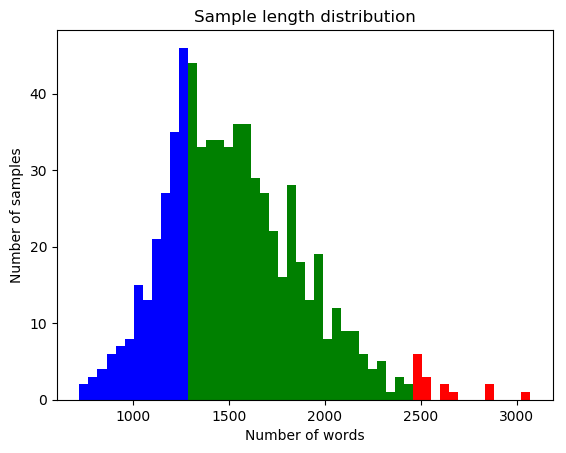

In [133]:
fig, ax = plt.subplots()
data = np.random.rand(1000)

N, bins, patches = ax.hist(word_count, edgecolor='white', bins=50, linewidth=0)

q1 = 0.25*len(patches)

q3 = 0.75*len(patches)
for i in range(0,int(q1)):
    patches[i].set_facecolor('b')
for i in range(int(q1), int(q3)):
    patches[i].set_facecolor('g')
for i in range(int(q3), len(patches)):
    patches[i].set_facecolor('r')
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()


In [129]:
stats = pd.Series(word_count)
q = pd.DataFrame(stats.describe()[3:]).transpose()
q

,min,25%,50%,75%,max
0,723.0,1273.5,1483.0,1747.0,3070.0


As we can see in the histogram and the five-number summary table, the job posting is quite lenthy in words. The shortest text has 723 words and the longest reach to 3070 words. Looking at the quantiles, we can see that less than 25% is under 1000 words and a majority of the job postings go over 1273.5. That lead to our next analysis quesion.

**2. Does the length of text effects the readability?**

In our test, we will calculate our readibility score based on the Flesch reading-ease test. The formula for the Flesch reading-ease score (FRES) test is

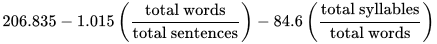

Higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The following table can be helpful to assess the ease of readability in a document.
The table is an example of values. 

| Score        | School level       | Notes                                                                   |
|--------------|--------------------|-------------------------------------------------------------------------|
| 100.00-90.00 | 5th grade          | Very easy to read. Easily understood by an average 11-year-old student. |
| 90.0–80.0    | 6th grade          | Easy to read. Conversational English for consumers.                     |
| 80.0–70.0    | 7th grade          | Fairly easy to read.                                                    |
| 70.0–60.0    | 8th & 9th grade    | Plain English. Easily understood by 13- to 15-year-old students.        |
| 60.0–50.0    | 10th to 12th grade | Fairly difficult to read.                                               |
| 50.0–30.0    | College            | Difficult to read.                                                      |
| 30.0–0.0     | College graduate   | Very difficult to read. Best understood by university graduates.        |

*Note: While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is valid.*

Luckily, the function of calculating Flesch reading-ease score is already built in the textstat package. We are going to use this library to analyze the readability of our raw text:

In [27]:
import textstat
score_list = []
for text in job_data:
    score_list.append(textstat.flesch_reading_ease(text))

In [28]:
readability["SCORE"] = score_list[:len(score_list)-1]
readability.head(10)

C:\Users\lykha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lykha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,FILE_NAME,WORD COUNTS,SCORE
0,311 DIRECTOR 9206 041814.txt,1531,-14.24
1,ACCOUNTANT 1513 062218.txt,1642,-9.20
2,ACCOUNTING CLERK 1223 071318.txt,1602,4.24
3,ACCOUNTING RECORDS SUPERVISOR 1119 072718.txt,1270,-29.57
4,ADMINISTRATIVE ANALYST 1590 060118.txt,1830,-24.80
5,ADMINISTRATIVE CLERK 1358 033018 (2).txt,1310,-19.52
6,ADMINISTRATIVE HEARING EXAMINER 9135 100915.txt,1605,-7.48
7,ADVANCE PRACTICE PROVIDER CORRECTIONAL CARE 23...,1114,-73.73
8,AIR CONDITIONING MECHANIC 3774 041417.txt,1856,-14.24
9,AIR CONDITIONING MECHANIC SUPERVISOR 3781 1116...,1750,-17.66


In [29]:
rstats = readability["SCORE"].describe()[3:]
pd.DataFrame(rstats).transpose()

,min,25%,50%,75%,max
SCORE,-351.7,-30.9725,-20.435,-11.03,14.43


Our max score is 14.43, which fall in the range 0-29 (very difficult to read), and the majority of the text data are negative numbers. This can be intepreted as the job postings are beyond the highest difficulty level to read in Flesch reading-ease test. Beside the lengthy words, the job posters may include many technical jargons and difficult requirements to understand in one reading. This may scare the applicants away since it make the job position seems harder than they actually are. 



**3. How can we fix this readability problem?**

That said, it’s a good idea to cut down your long lists not matter what—one study found that **the average jobseeker spends just 49.7 seconds reviewing a listing before deciding it’s not a fit.** Therefore, here're some suggestions to fix this problem: 

**Limit your job requirements to “must-haves”:**

Your hiring manager might have an unending list of qualifications in mind for a given role, but in order to highlight your commitment to inclusion, it’s important to trim the list down. That’s because studies show that while men are likely to apply to jobs for which they meet only 60% of the qualifications, women are much more likely to hesitate unless they meet 100% of the listed requirements. Instead of including all of the “nice-to-haves” that a dream candidate might possess, stick to the “must-haves,” and you’ll likely see your applications from women candidates increase. Or if you’d still like to call out certain desired skills, you can soften the message with language like “familiarity with,” “bonus points for,” or “if you have any combination of these skills.”

**Avoid using unnecessary corporate speak and jargon:**

One of the quickest ways to turn off candidates is to include loads of unnecessary jargon in your descriptions. That includes things like KPIs, procurement, SLAs, P&L, and so on. While candidates with plenty of experience in a similar role might know what you’re talking about, studies show jargon and corporate language in job postings is one of the biggest barriers keeping talented young people from applying to entry-level positions. These subtle word choices can make some candidates feel unqualified for a position that they’re absolutely qualified for. “Insider language is a quick way to make someone else feel like an outsider, but if you’re not watching out for it, acronyms and ‘company speak’ will inevitably creep into your job descriptions,” says HubSpot’s Hannah Fleishman. “When in doubt, assume the candidate doesn’t know the ins-and-outs of your company.”

*For example, instead of using technical acronyms and business terms in your requirements, aim for more universal wording, like “pays attention to details” or “personable with customers.”*

## PART 3: SENTIMENT ANALYSIS:

**1. Cleaning the data:**

In order to perform sentiment analysis, we need to clean up the raw data to extract only the essential features. With that being said, we first need to tokenize the text. Tokenization is the process of breaking down a text paragraph into smaller chunks such as words or sentence. We also need to remove unnecessary words by including them in stopword list. In this case, "city, los angeles, and may" are removed since they shows up as most frequent words and does not carry much weights in our classification process later.

In [30]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
#
newStopWords = ['city','los','angele','angeles','may']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

lemma = WordNetLemmatizer()
porter = PorterStemmer()

We also perform Lexicon normalization. The normalization process considers another type of noise in the text. For example, "connection", "connected", "connecting" are reduced to the common word "connect". It reduces derivationally related forms of a word to a common root word.

In [31]:
def normalize_document(doc):
    #replace newline and tab chars
    doc = doc.replace("\\r\\n"," ").replace("\\\'s","").replace("\t"," ") #.split("b'")[1]
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    #normalized = " ".join(lemma.lemmatize(word) for word in filtered_tokens)
    #join the tokens back to get the original doc
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
#apply the text normalization to list of job positions
norm_positions=[]
for text_sample in positions:
    norm_positions.append(normalize_document(text_sample))
#apply the text normalization to list of job ads
norm_corpus=[]
for text_sample in job_data:
    norm_corpus.append(normalize_document(text_sample))

**2. Sentiment analysis on n-grams:**

After we cleaning up the text to extract only the most important information, we are going to plot our normalized texts for further analysis.
First, we would plot a word clouds. It is a good visualization to show the most frequently used words in the job posting text. The more frequent a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud.

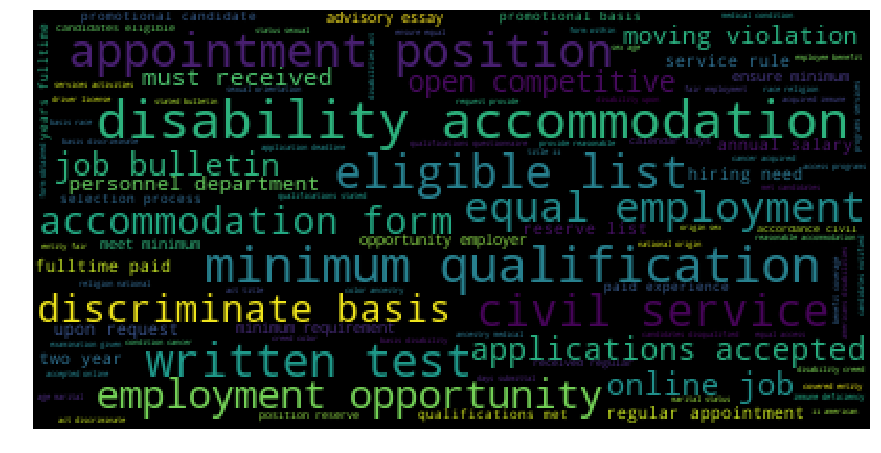

In [32]:
full_norm_corpus=' '.join(norm_corpus)
stopwords = set(STOPWORDS)
stopwords.update(["class", "code"])

wordcloud = WordCloud(stopwords=stopwords,max_words=100).generate(full_norm_corpus)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud, we can see some positive and negative keywords showing up:

**Positive words:** "disability accommodation", "civil service", "open competitive", "equal employment", "employment opportunity".

Those terms provoke a positive feeling that the employers really value diversity and welcome applicants from all backgrounds, genders and situations to apply. 

**Negative words:** "written test", "must received", "eligible list", "minimum qualification", "service rule", "reserve list"

These terms, in contrast, give a negative impression that the employers follow very strict rules and have many requirements for the job opening. That will discourage many applicants. 

We will create a n-grams function to extract longer terms and plot top 30 most frequent terms:

In [33]:
def ngrams(sample_texts, ngram_range, num_ngrams=30):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    return ngrams, counts


ngrams4, counts4 = ngrams(norm_corpus,ngram_range=(4, 4))    

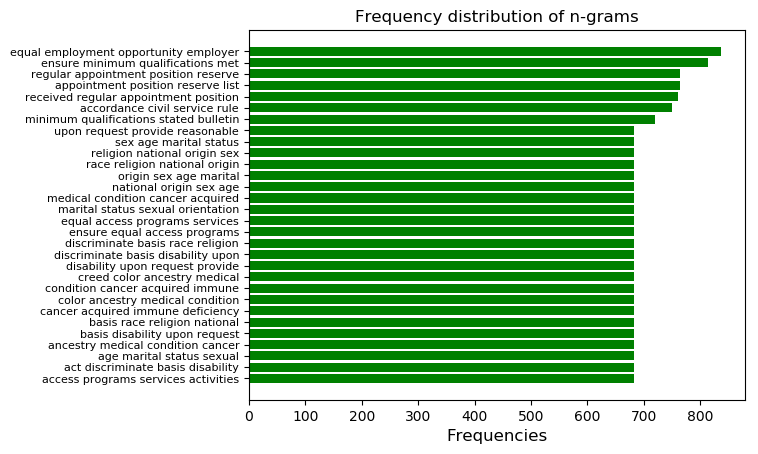

In [34]:
# Fixing random state for reproducibility
idx = np.arange(30)
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()
#horizontal
ax.barh(idx, counts4, align='center', color='g')
ax.set_yticks(idx)
ax.set_yticklabels(ngrams4, rotation=0, fontsize=8)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequencies',fontsize="12")
ax.set_title('Frequency distribution of n-grams',fontsize="12")

plt.show()

We will use the textblob library, which has a pre-trained machine learning model, to classify whether our 4-gram term are positive ore negative. By default, the NaiveBayesClassifier uses a simple feature extractor that indicates which words in the training set (movie reviews datset) are contained in a document. The textblob model take into consideration the tone and content of the text and can classify with an accuracy of 87%. An example of the classification can be:

In [35]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
#nltk.download('movie_reviews')
#nltk.download('punkt')

text          = "I only hire male applicants" 

sent          = TextBlob(text)
# The polarity score is a float within the range [-1.0, 1.0]
# where negative value indicates negative text and positive
# value indicates that the given text is positive.
polarity      = sent.sentiment.polarity
# The subjectivity is a float within the range [0.0, 1.0] where
# 0.0 is very objective and 1.0 is very subjective.
subjectivity  = sent.sentiment.subjectivity

sent          = TextBlob(text, analyzer = NaiveBayesAnalyzer())
classification= sent.sentiment.classification
positive      = sent.sentiment.p_pos
negative      = sent.sentiment.p_neg


dict1 = {'Polarity': polarity,'Subjectivity': subjectivity, 'Classification': classification, 'Posititve': positive, 'Negative': negative}
df1 = pd.Series(dict1)
df1

Polarity                 0
Subjectivity          0.55
Classification         neg
Posititve         0.218674
Negative          0.781326
dtype: object

In [36]:
def pos_neg_classify(text):
    sent          = TextBlob(text)
    # The polarity score is a float within the range [-1.0, 1.0]
    # where negative value indicates negative text and positive
    # value indicates that the given text is positive.
    polarity      = sent.sentiment.polarity
        
    # The subjectivity is a float within the range [0.0, 1.0] where
    # 0.0 is very objective and 1.0 is very subjective.
    subjectivity  = sent.sentiment.subjectivity
    
    sent          = TextBlob(text, analyzer = NaiveBayesAnalyzer())
    classification= sent.sentiment.classification
    pos_score = round(sent.sentiment.p_pos,2)
    neg_score = round(sent.sentiment.p_neg,2)
    if pos_score > neg_score:
        clas = 'POSITIVE'
    elif pos_score < neg_score:
        clas = 'NEGATIVE'
    else:
        clas = 'NEUTRAL'
    return clas

def polarity_classify(text):
    sent          = TextBlob(text)
    # The polarity score is a float within the range [-1.0, 1.0]
    # where negative value indicates negative text and positive
    # value indicates that the given text is positive.
    polarity      = round(sent.sentiment.polarity, 1)
    
    if polarity > 0:
        pol = 'EMOTIONAL POSITIVE'
    elif polarity < 0:
        pol = 'EMOTIONAL NEGATIVE'
    else:
        pol = 'EMOTIONAL NEUTRAL'
        
    return pol

In [37]:
pd.set_option('display.max_colwidth', -1)
df_4 = pd.DataFrame(ngrams4, columns=['N-grams Sentence'])
class_list4 = []
pol_list4 = []
for text in ngrams4:
    classification = pos_neg_classify(text)
    polarity = polarity_classify(text)
    class_list4.append(classification)
    pol_list4.append(polarity)
df_4["Content"] = class_list4
df_4["Polarity"] = pol_list4
df_4

,N-grams Sentence,Content,Polarity
0,equal employment opportunity employer,POSITIVE,EMOTIONAL NEUTRAL
1,ensure minimum qualifications met,NEGATIVE,EMOTIONAL NEUTRAL
2,regular appointment position reserve,POSITIVE,EMOTIONAL NEUTRAL
3,appointment position reserve list,POSITIVE,EMOTIONAL NEUTRAL
4,received regular appointment position,POSITIVE,EMOTIONAL NEUTRAL
5,accordance civil service rule,POSITIVE,EMOTIONAL NEUTRAL
6,minimum qualifications stated bulletin,NEGATIVE,EMOTIONAL NEUTRAL
7,upon request provide reasonable,POSITIVE,EMOTIONAL POSITIVE
8,sex age marital status,POSITIVE,EMOTIONAL NEUTRAL
9,religion national origin sex,POSITIVE,EMOTIONAL NEUTRAL


In [38]:
df_4_neg = df_4[df_4["Content"]=="NEGATIVE"]
df_4_neg

,N-grams Sentence,Content,Polarity
1,ensure minimum qualifications met,NEGATIVE,EMOTIONAL NEUTRAL
6,minimum qualifications stated bulletin,NEGATIVE,EMOTIONAL NEUTRAL
11,origin sex age marital,NEGATIVE,EMOTIONAL NEUTRAL
12,national origin sex age,NEGATIVE,EMOTIONAL NEUTRAL
21,condition cancer acquired immune,NEGATIVE,EMOTIONAL NEUTRAL
23,cancer acquired immune deficiency,NEGATIVE,EMOTIONAL NEUTRAL


In [139]:
neg_4grams = df_4_neg["N-grams Sentence"]
neg_list = []
class_list10 = []
pol_list10 = []
ngrams10, counts10 = ngrams(norm_corpus,ngram_range=(10, 10))   
for text in ngrams10:
    for neg_word in neg_4grams:
        neg_index = text.find(neg_word)    
        if neg_index != -1:
            if text not in neg_list:
                neg_list.append(text)
                classification = pos_neg_classify(text)
                polarity = polarity_classify(text)
                class_list10.append(classification)
                pol_list10.append(polarity)
                
df_neg = pd.DataFrame(neg_list, columns=['N-grams Sentence'])
df_neg["Content"] = class_list10
df_neg["Polarity"] = pol_list10
df_neg

,N-grams Sentence,Content,Polarity
0,race religion national origin sex age marital status sexual orientation,POSITIVE,EMOTIONAL POSITIVE
1,discriminate basis race religion national origin sex age marital status,POSITIVE,EMOTIONAL NEUTRAL
2,basis race religion national origin sex age marital status sexual,POSITIVE,EMOTIONAL POSITIVE
3,disability creed color ancestry medical condition cancer acquired immune deficiency,POSITIVE,EMOTIONAL NEUTRAL
4,basis discriminate basis race religion national origin sex age marital,POSITIVE,EMOTIONAL NEUTRAL
5,creed color ancestry medical condition cancer acquired immune deficiency syndrome,POSITIVE,EMOTIONAL NEUTRAL
6,expression disability creed color ancestry medical condition cancer acquired immune,POSITIVE,EMOTIONAL NEUTRAL
7,subject review ensure minimum qualifications met candidates disqualified time determined,POSITIVE,EMOTIONAL NEGATIVE
8,religion national origin sex age marital status sexual orientation gender,POSITIVE,EMOTIONAL POSITIVE
9,origin sex age marital status sexual orientation gender identity gender,POSITIVE,EMOTIONAL POSITIVE


## PART 3: Suggestions:

**According to our findings, the job postings include many negative words in the requirement section. Therefore, below are 5 additional suggestions that can fix the sentiment problems in order to improve the diversity hiring at city of LA:**

**1. Re-word your job posting to attract diversity:**

The current job postings include a big part talking about requirements, standard tests and applying process. It's like a teacher gives a long list of homeworks and assignments on the first day of class. Hence, those information will scare many job seekers away. As we mentioned in part 2, we should cut down the length of text to increase the readibility of the job postings. The testing requirements and application processes can definitely cut down from our posting. These processes can be included in a follow-up email to candidates who actually apply to the job.

In addition, many studies has found that the language you use in a job description can significantly attract or turn off diverse candidates from applying to the listed position. To attract more female candidates, avoid using too many “masculine” words (ambitious, dominate, challenging ...) in the job postings. 

**2. Show your existing workplace diversity (or the diversity you aspire to):**

Glassdoor found that 67% of job seekers use diversity is an important factor when considering companies and job offers. One of the biggest effective way to increase workplace diversity is showing diversity at your workplace itself. 
In February of 2018, Mayor Eric Garcetti today did a really good job in creating a social media campaign that highlighted diversity in the Los Angeles Police Department and encourage more Angelenos to consider careers in the LAPD. One of the photo banner from this campaign shows different LAPD employees holding paper signs telling their unique personal stories (the picture attached below). The city of LA can work on a similar campaign with real employees from each department. 

![Source](Campaign_Image.PNG)
*Source: LA Mayor's website*

**3. Encourage referrals from minority employees:**

Current employee at your organization usually has professional networks are made up of people from the similar demographic. You can leverage this diverse network advantage by encouraging minority employees (with or without bonuses) to give referrals. A great amount of referrals from minority employee will help increase your diversity hiring drastically.


**4. Call out inclusive benefits like parental leave and childcare subsidies:**

Beside salary, company benifits is the second key point that an average job seekers scan through when they read a job posting. Thereforem bring those two important pieces of information to the top of the page. Good salary, paid parental leave, childcare subsidies, paid family sick time, and even health insurance can go a long way toward supporting and attracting diversity and inclusion. It also shows the company actually care about the well-being of their employees. 

**5. Offer workplace flexibility:**

Research has found a strong correlation between employees’ quitting and a long commute distance. Therefore, offering flexible work hours and even work from home option does not only attract more diverse candidates, it also helps reduce some operating expenses. 

## PART 4: SUGGESTION VALIDATION:

It's easier to say than done. Let's take all our suggestions into consideration and create a revised job postings. Below is a revised job sample:

In [40]:
old_jobposting = open('CityofLA\Job Bulletins\ADMINISTRATIVE ANALYST 1590 060118.txt', 'r')
content1 = old_jobposting.read()

In [41]:
import textstat
print("Statistics of Revised Job Posting:")
numword = textstat.lexicon_count(content1, removepunct=True)
score = textstat.flesch_reading_ease(content1)
class1 = pos_neg_classify(content1)
pol1         = polarity_classify(content1)
contentstat1 = pd.Series({"Word counts": numword, "Readbility Score": score, "Content": class1, "Polarity": pol1})
contentstat1

Statistics of Revised Job Posting:


Word counts         1549             
Readbility Score   -8.29             
Content             POSITIVE         
Polarity            EMOTIONAL NEUTRAL
dtype: object

In [42]:
revised_jobposting = open('Diversity_Hiring.txt', 'r')
content2 = revised_jobposting.read()
print(content2)

ADMINISTRATIVE ANALYST

Class Code:       1590
Open Date:  06-01-18
(Exam Open to Current City Employees)

ANNUAL SALARY:

$60,489 to $88,468 and $71,451 to $104,462

BENEFITS:
Vacation and Sick Leave
Paid Holoday
Health and Life Insurance
Parential Leaves and Child Subsidies
Retirement Plan
Accommodations for disability (if applicable)

DUTIES:
An Administrative Analyst performs professional work in the Office of the City Administrative Officer. Duties include:
•	Investigating, assembling, and interpreting facts 
•	Making reports 
•	Recommendations in administrative, fiscal, budgetary, compensation, facilities, contract analysis, capital projects or procedural analysis of City activities and services.

REQUIREMENTS/MINIMUM QUALIFICATIONS: 
1. One year of full-time paid professional experience as a Management Assistant with the City of Los Angeles experience, or
2. Two years of full-time paid experience as a Management Aide with the City of Los Angeles with experience (Note: A bachelor

In [43]:
import textstat
print("Statistics of Revised Job Posting:")
numword = textstat.lexicon_count(content2, removepunct=True)
score = textstat.flesch_reading_ease(content2)
class2 = pos_neg_classify(content2)
pol2         = polarity_classify(content2)
contentstat2 = pd.Series({"Word counts": numword, "Readbility Score": score, "Content": class2, "Polarity": pol2})
contentstat2

Statistics of Revised Job Posting:


Word counts         329               
Readbility Score    12.84             
Content             POSITIVE          
Polarity            EMOTIONAL POSITIVE
dtype: object

The readability score does have fewer words, remain the positive tone and improve from a negative readability score to a college-level readability score of 12.84. Therefore, our suggestion does help improve the sample job posting.

**Since our suggestion works well in improving the readbility and semtiment of the original text, let's put all our above sugestions from part 3 into a nicer and cleaner posting. Below is my detailed comments on what I changed from the original text:**

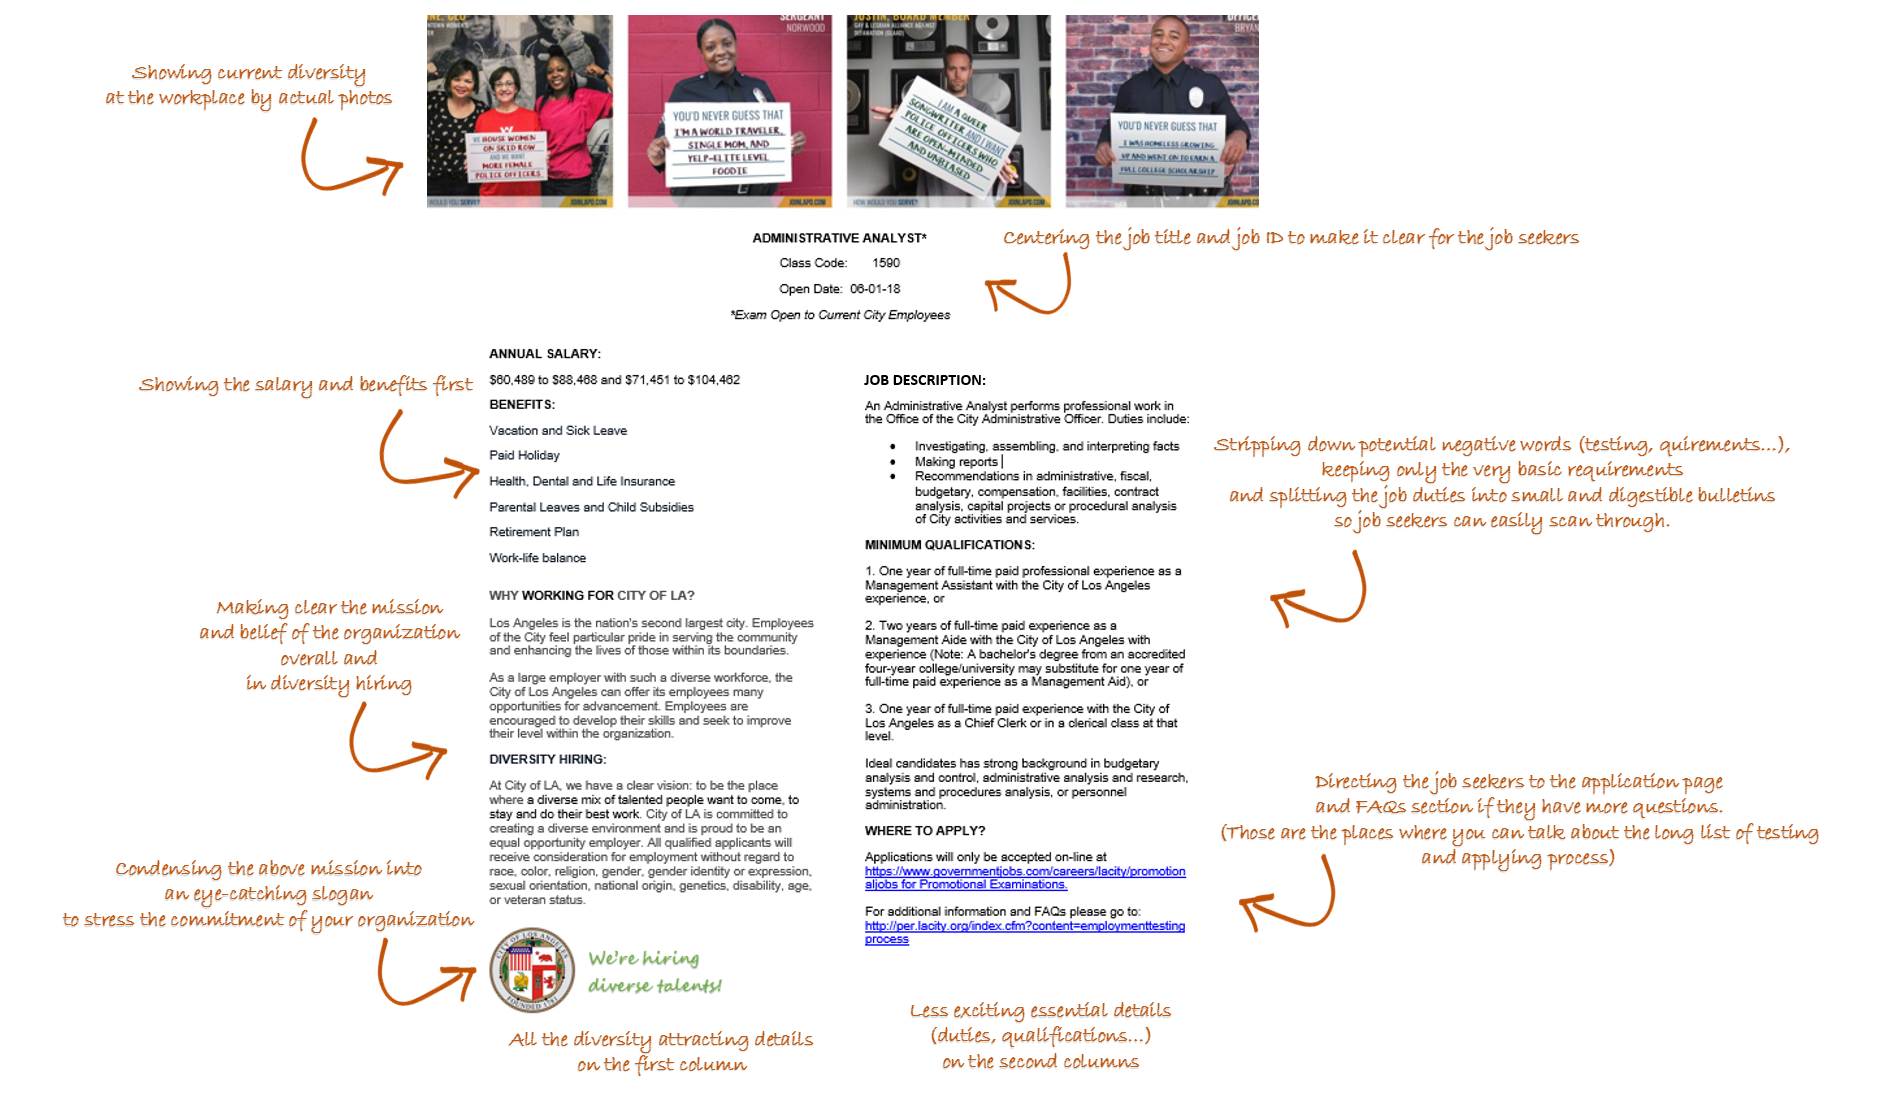

In [44]:
from IPython.display import Image
Image("Suggestion with comments.png")

**Original job positing:**

In [45]:
print(content1)

ADMINISTRATIVE ANALYST

Class Code:       1590
Open Date:  06-01-18
(Exam Open to Current City Employees)

ANNUAL SALARY

$60,489 to $88,468 and $71,451 to $104,462

NOTES:

1. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.
2. Annual salary is at the start of the pay range. The current salary range is subject to change. Please confirm the starting salary with the hiring department before accepting a job offer.

DUTIES

An Administrative Analyst performs professional work in the Office of the City Administrative Officer investigating, assembling, and interpreting facts and making reports and recommendations in administrative, fiscal, budgetary, compensation, facilities, contract analysis, capital projects or procedural analysis of City activities and services.

REQUIREMENTS/MINIMUM QUALIFICATIONS

1. One year of full-time paid professional experience as a Management Assistant with the City of Los Angeles with experience in budgeta

**Our final revised job posting:**

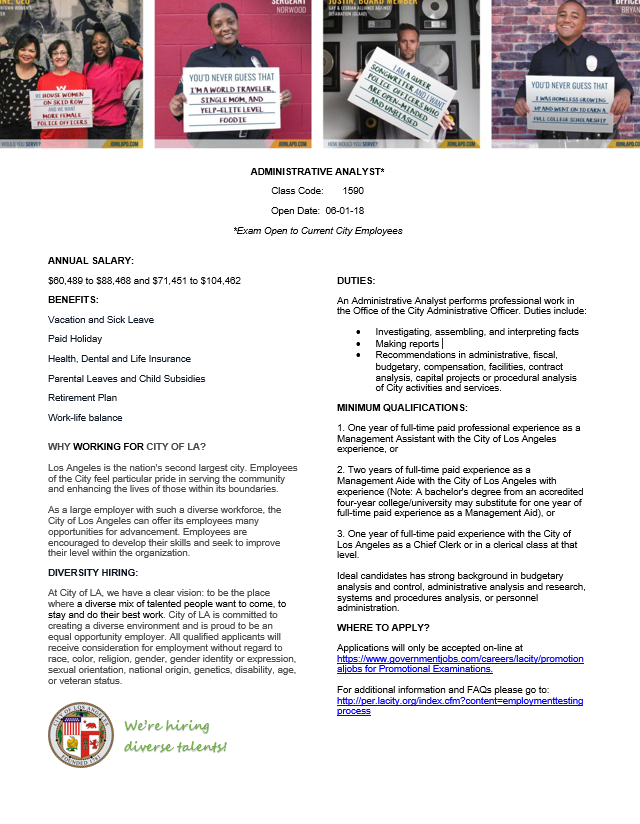

In [46]:
Image("diversity hiring posting 2.png")

Looking at the above job posting and comparing to the text file of the same position from the dataset, which ones would you refer to read and feel more comfortable to take action to apply for? Ypu may already have your answer. 

**PART 6: CONCLUSION**

In summary, we first extract the information from the plain text job postings to create a csv table. Then, we use this new csv table and the normalized text files for the purpose of calculating ngrams of most frequently appeared words, plotting the distribution of text length, word clouds and sentiment analysis of the ngrams. From our analytics, we can see that the job posting texts are lenghty in words, have low readability scores, contain many negative words. 
By focusing on fixing the length of the text, filtering out the negative words, adding a some other suggestions on promoting the company's mission and commitment to diversity hiring, we then validate our suggestions by running the metrics from our analysis on the new text. In our last step, we add graphic and reformat the plain text into a neat and clean job posting. This new job posting can play a key part helping the city of LA to meet their goal in diversity hiring the future. 

## REFERENCES: